In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View

In [14]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

KeyboardInterrupt: 

In [ ]:
#TO FIT STRAIGHT LINES

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def fitting(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    
    resis = []
    gradients = []
    intercepts = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    particleType = np.array([])
    
    for i in idx:
        pdg = events.mc_pdg[i]
        particleType = np.append(particleType, pdg)
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 100
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            gradients.append(m)
            intercepts.append(c)
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
                plt.show()
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            resis.append(mean)
        else:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
            #print("No inliers found for a particle")
            continue
    
    return gradients, intercepts, resis, particleType

In [ ]:
def var_se(event_number):
    """needs to return the ratio of the variance of the first X% divided by the last Y%
    in the residuals for each particle"""
    
    particleType = np.array([])
    
    results = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    # Fitting each particle with a straight line.
    m, c, _, _ = fitting(event_number, False)
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        
        # CUTS
        
        # Discarding particles with little hits
        if x.size <= 10:
            continue
            
        if events.mc_pdg[i] == 0:
            continue
        
        if events.purity[i] < 0.75:
            continue
            
        if events.completeness[i] < 0.75:
            continue
            
        else:   
            
            # Changing coordinates to along and transverse
            if m[i-idx[0]] == 0:
                continue
            else:
                znew = z - c[i-idx[0]]
                angle = -math.atan(m[i-idx[0]])
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
                
                #last 30% of data
                p1 = int(0.7 * len(t))
                X = t[p1:]
                if len(X) == 0 or np.any(np.isnan(X)) or np.any(np.isinf(X)):
                    continue
                else:
                    Xvar = np.var(X)
                
                #first 30% of data
                p2 = int(0.3 * len(t))
                Y = t[:p2]
                if len(Y) == 0 or np.any(np.isnan(Y)) or np.any(np.isinf(Y)):
                    continue
                else:
                    Yvar = np.var(Y)
                
                if Yvar == 0 or Xvar == 0 or math.isinf(Yvar) or math.isinf(Xvar) or np.isnan(Xvar) or np.isnan(Yvar) :
                    continue
                    
                if  Yvar > Xvar:
                    resultY = np.sqrt(Yvar)
                    results = np.append(results, resultY)
                    
                    pdg = events.mc_pdg[i]
                    particleType = np.append(particleType, pdg)
                
                else:
                    resultX = np.sqrt(Xvar)
                    results = np.append(results, resultX)
                    
                    # Finding the particle type
                    pdg = events.mc_pdg[i]
                    particleType = np.append(particleType, pdg) 

    return results, particleType

In [ ]:
def symmetry(event_number):
    """Returns a measure of symmetry for each particle's track by dividing how many are 
    above line of best fit by how many are below the line (or the absolute value of the difference?)"""
    
    particleType = np.array([])
    allSym = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    # Fitting each particle with a straight line.
    m, c, _, _ = fitting(event_number, False)
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        
        # CUTS
        
        # Discarding particles with little hits
        if x.size <= 10:
            continue
            
        if events.mc_pdg[i] == 0:
            continue
        
        if events.purity[i] < 0.75:
            continue
            
        if events.completeness[i] < 0.75:
            continue
            
        else:   
            
            # Changing coordinates to along and transverse
            if m[i-idx[0]] == 0:
                continue
            else:
                znew = z - c[i-idx[0]]
                angle = -math.atan(m[i-idx[0]])
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
                
                # How many particles are above or below the line?
                above = np.sum(t > 0)
                below = np.sum(t < 0)
                
                lmin, lmax = np.min(l), np.max(l)
                length = lmax - lmin

                
                if above == 0 or below == 0 or length == 0:
                    continue
                    
                else:
                    
                    # If symmetric, this should be close to 1, otherwise > 1
                    sym = (above + below) / length
                    allSym = np.append(allSym, sym)
                    
                    pdg = events.mc_pdg[i]
                    particleType = np.append(particleType, pdg)
                
    return allSym, particleType

In [ ]:
def hits(event_number):
    """Needs to return number of hits divided by the 
    length of the particle track/shower, and the particle type"""
    
    # Accessing a specific event.
    idx = np.where(events.event_number == event_number)[0]
    
    particleType = np.array([])
    allHits = np.array([])
    
    # Fitting each particle with a straight line.
    m, c, _, _ = fitting(event_number, False)
    
    # Looping through each particle from the event
    for i in idx:
        
        # The position coordinates for the particle
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        
        # CUTS
        
        # Discarding particles with little hits
        if x.size <= 10:
            continue
            
        if events.mc_pdg[i] == 0:
            continue
        
        if events.purity[i] < 0.75:
            continue
            
        if events.completeness[i] < 0.75:
            continue
            
        else:
            
            # Changing coordinates to along and transverse
            if m[i-idx[0]] == 0:
                continue
            else:
                znew = z - c[i-idx[0]]
                angle = -math.atan(m[i-idx[0]])
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
            
            # The number of hits
            hit = len(l)
            
            lmin, lmax = np.min(l), np.max(l)
        
            length = lmax - lmin
            
#             if length == 0:
#                 continue
                
#             else:
            result = hit / length
            allHits = np.append(allHits, result)

            # Finding the particle type
            pdg = events.mc_pdg[i]
            particleType = np.append(particleType, pdg)

        
    return allHits, particleType

In [ ]:
def energy(event_number):
    """needs to return energy in last X% over total energy"""
    
    particleType = np.array([])
    E = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]        
        
        # CUTS
        
        # Discarding particles with little hits
        if x.size <= 10:
            continue
            
        if events.mc_pdg[i] == 0:
            continue
        
        if events.purity[i] < 0.75:
            continue
            
        if events.completeness[i] < 0.75:
            continue
            
        else:
            
            # Get the last 10% of the energy data
            percent = int(0.9 * len(adc))
            X = adc[percent:]
            Xsum = np.sum(X)
            
            total = np.sum(adc)
            result = Xsum / total
            
            E = np.append(E, result)
            
            # Finding the particle type
            pdg = events.mc_pdg[i]
            particleType = np.append(particleType, pdg)   
            
            
    return E, particleType

In [ ]:
SAMPLE = np.random.randint(0, max(events.event_number), 500)

In [ ]:
SAMPLE

array([3786, 4043, 5683, 5347, 2318, 6486, 1537, 7145, 5188,  110, 5747,
       4502, 3822, 4209,  127,  181, 1851, 7045, 5435,  210, 5314, 2384,
       8249, 1722, 7415, 1891, 2748, 2485, 4167, 2417, 2134, 1089, 4050,
        298, 1564, 9008, 8562, 7527, 4991, 7643, 6527, 3588, 4272, 3675,
       7200, 2486, 4523, 4530, 4385, 3120, 3049, 1711, 5343, 7444, 7442,
        114, 6278, 7710, 7129, 3365, 6522,  263,  556, 1167, 2845, 1691,
       5961, 2010, 7228, 7880, 4738, 4829, 6009, 1476, 7263, 6038, 9065,
       1059, 5852, 2443, 4194, 9240, 4118, 7480, 5016, 9174, 2957, 1922,
       1784, 7328, 4705, 7078, 6820, 8848, 6690, 5201, 5803, 6095,  790,
        696, 4578, 6938,  567, 4709, 3642, 2686, 8404, 6091,  139, 2595,
       4775, 2605, 4336, 9141, 2659, 6183, 5888,  226, 2481, 2338, 9304,
       8874, 7292, 6557, 7377, 1363, 7032, 2495, 2282, 8457,   57, 1274,
       8151, 4361,  493, 5380, 4212,  300, 1011, 2562, 9129, 7077, 4805,
       9159, 5895, 5006, 8514, 1217, 3464,  452, 72

In [ ]:
v = np.array([])
pv = np.array([])
iteration = 0
for i in SAMPLE:
    v, pv = np.append(v, var_se(i)[0]), np.append(pv, var_se(i)[1])
    print(f"Iteration number: {iteration}")
    iteration += 1  # Increment the counter

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Iteration number: 0
Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14
Iteration number: 15
Iteration number: 16
Iteration number: 17
Iteration number: 18
Iteration number: 19
Iteration number: 20
Iteration number: 21
Iteration number: 22
Iteration number: 23
Iteration number: 24
Iteration number: 25
Iteration number: 26
Iteration number: 27
Iteration number: 28
Iteration number: 29
Iteration number: 30
Iteration number: 31
Iteration number: 32
Iteration number: 33
Iteration number: 34
Iteration number: 35
Iteration number: 36
Iteration number: 37
Iteration number: 38
Iteration number: 39
Iteration number: 40
Iteration number: 41
Iteration number: 42
Iteration number: 43
Iteration number: 44
Iteration number: 45
Iteration number: 46
Iteration number: 47
It

In [ ]:
len(v), len(pv)

(2412, 2412)

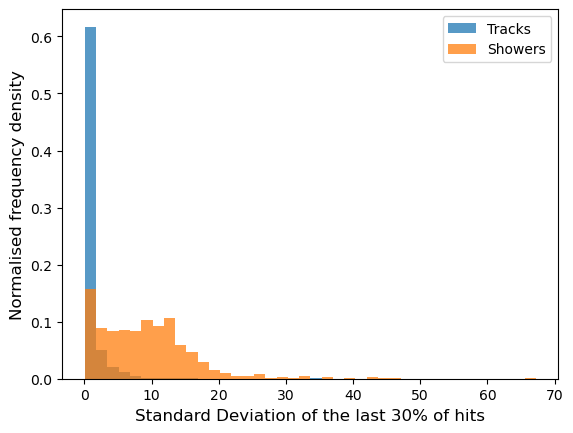

In [15]:
df = pd.DataFrame({"variance": v, "particle": pv})

# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['variance'].values
showers = fshowers['variance'].values

n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
# plt.title("Using standard deviation in residuals to distinguish tracks and showers")
plt.ylabel("Normalised frequency density",fontsize=12)
plt.xlabel("Standard Deviation of the last 30% of hits", fontsize=12)

plt.legend()

plt.savefig('stdHistogram.png', dpi=500)
plt.show()

In [ ]:
h = []
ph = []
for i in SAMPLE:
    h, ph = np.append(h, hits(i)[0]), np.append(ph, hits(i)[1])

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
len(h), len(ph)

(4291, 4291)

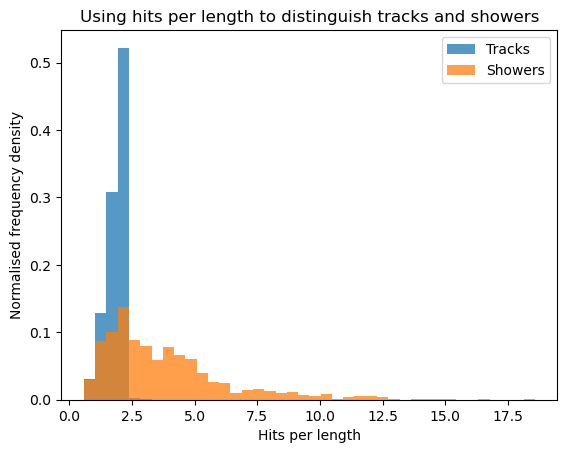

In [ ]:
df = pd.DataFrame({"hits": h, "particle": ph})

# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['hits'].values
showers = fshowers['hits'].values

n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
plt.title("Using hits per length to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Hits per length")

plt.legend()
plt.show()

In [ ]:
# DEVIATION PER LENGTH

In [ ]:
s = []
ps = []
iteration = 0
for i in SAMPLE:
    s, ps = np.append(s, symmetry(i)[0]), np.append(ps, symmetry(i)[1])
    print(f"Iteration number: {iteration}")
    iteration += 1  # Increment the counter

Iteration number: 0
Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14
Iteration number: 15
Iteration number: 16
Iteration number: 17
Iteration number: 18
Iteration number: 19
Iteration number: 20
Iteration number: 21
Iteration number: 22
Iteration number: 23
Iteration number: 24
Iteration number: 25
Iteration number: 26
Iteration number: 27
Iteration number: 28
Iteration number: 29
Iteration number: 30
Iteration number: 31
Iteration number: 32
Iteration number: 33
Iteration number: 34
Iteration number: 35
Iteration number: 36
Iteration number: 37
Iteration number: 38
Iteration number: 39
Iteration number: 40
Iteration number: 41
Iteration number: 42
Iteration number: 43
Iteration number: 44
Iteration number: 45
Iteration number: 46
Iteration number: 47
It

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
len(s), len(ps)

(529, 529)

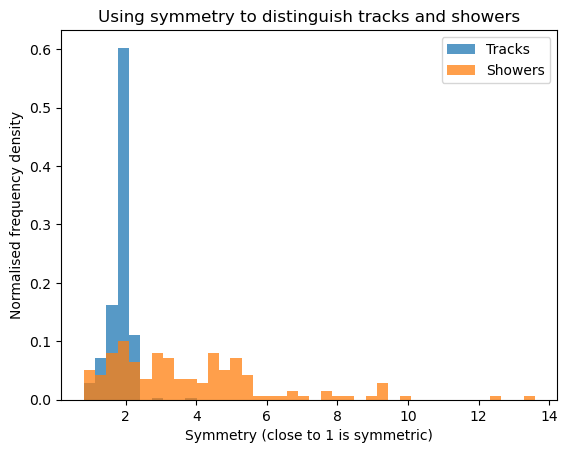

In [ ]:
df = pd.DataFrame({"symmetry": s, "particle": ps})

# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['symmetry'].values
showers = fshowers['symmetry'].values

n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
plt.title("Using symmetry to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Symmetry (close to 1 is symmetric)")
# plt.xlim(-1, 30)

plt.legend()
plt.show()

In [ ]:
# ENERGY

In [ ]:
e = []
pe = []
for i in SAMPLE:
    e, pe = np.append(e, energy(i)[0]), np.append(pe, energy(i)[1])

In [ ]:
len(e), len(pe)

(4858, 4858)

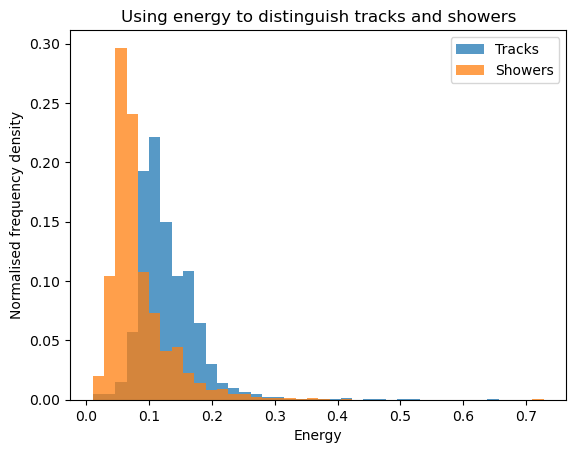

In [ ]:
df = pd.DataFrame({"energy": e, "particle": pe})

# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['energy'].values
showers = fshowers['energy'].values

n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
plt.title("Using energy to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Energy")

plt.legend()
plt.show()

In [ ]:
data = np.column_stack((v,s,h,e))

In [ ]:
correlation = np.corrcoef(data, rowvar=False)
correlation

array([[ 1.        ,  0.5831459 ,  0.58332533, -0.44149488],
       [ 0.5831459 ,  1.        ,  0.999933  , -0.35649527],
       [ 0.58332533,  0.999933  ,  1.        , -0.35664167],
       [-0.44149488, -0.35649527, -0.35664167,  1.        ]])

In [ ]:
equal = np.array_equal(pv,ps) and np.array_equal(ps,ph) and np.array_equal(ph,pe)
equal

True

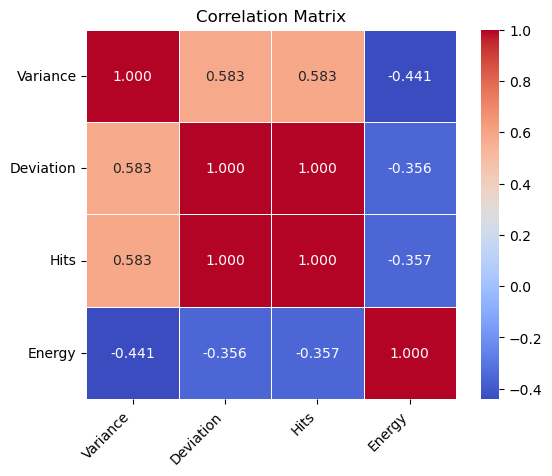

In [ ]:
%matplotlib inline

variable_names = ['Variance', 'Deviation', 'Hits', 'Energy']

heatmap = sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=True)
heatmap.set_xticklabels(variable_names, rotation=45, ha='right')
heatmap.set_yticklabels(variable_names, rotation=0)

plt.title("Correlation Matrix")
plt.show()